# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import required packages

In [4]:
from pathlib import Path
from dreaminsg_integrated_model.src.network_recovery import *
# import dreaminsg_integrated_model.src.plots as model_plots
import dreaminsg_integrated_model.src.simulation as simulation
from dreaminsg_integrated_model.src.network_sim_models.integrated_network import *
from dreaminsg_integrated_model.src.optimizer import *

from sklearn import metrics

## Create an IntegratedNetwork object

In [5]:
simple_network = IntegratedNetwork()

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [6]:
network_dir= 'in2'

MAIN_DIR = Path('..')
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/Example_water2.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/Example_power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_file, power_file, transp_folder)

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\water\Example_water2.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\power\Example_power.json

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.
Iteration 1: gap 0.000305: time 0.000986
Iteration 2: gap 0.000000: time 0.004011


### Create a Networkx graph of the integrated infrastructure network.

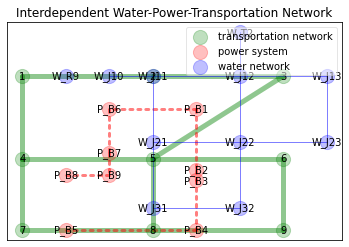

In [7]:
simple_network.generate_integrated_graph(plotting = False)

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [8]:
dependency_file = MAIN_DIR/"dreaminsg_integrated_model/data/networks/in2/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [9]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,4,power,Bus,125.00
1,P_B7,5,power,Bus,103.08
2,P_B5,7,power,Bus,100.00
3,P_B4,8,power,Bus,100.00
4,P_B6,2,power,Bus,180.28


### Set failed components

In [10]:
scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/test1/motor_failure_net1.csv"
simple_network.set_disrupted_components(scenario_file=scenario_file)

In [11]:
simple_network.pipe_leak_node_generator()

### Set initial crew locations

In [12]:
simple_network.set_init_crew_locs(init_power_loc=8,
init_water_loc=8, init_transpo_loc=8)

## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery and Optimizer objects

In [13]:
network_recovery = NetworkRecovery(simple_network, 60)
bf_optimizer = BruteForceOptimizer(prediction_horizon = 2)

### (b) Create a simulation object

In [15]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Optimization of repair strategy

PREDICTION HORIZON 1
**************************************************
Components to repair:  ['P_MP1', 'P_L2', 'P_LO1', 'W_P22'] Components repaired:  []
Repair orders under consideration in the current prediction horizon:  [['P_MP1', 'P_L2'], ['P_MP1', 'P_LO1'], ['P_MP1', 'W_P22'], ['P_L2', 'P_MP1'], ['P_L2', 'P_LO1'], ['P_L2', 'W_P22'], ['P_LO1', 'P_MP1'], ['P_LO1', 'P_L2'], ['P_LO1', 'W_P22'], ['W_P22', 'P_MP1'], ['W_P22', 'P_L2'], ['W_P22', 'P_LO1']]
--------------------------------------------------
Simulating the current cumulative repair order ['P_MP1', 'P_L2'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: A

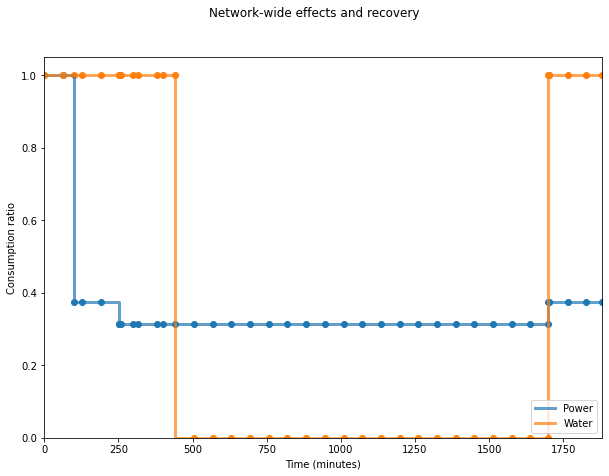

Water AUC:  0.348 	 Power AUC:  0.353 	 Weighted AUC:  0.351
Simulating the current cumulative repair order ['P_MP1', 'P_LO1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
2       18000      P_LO1         25
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


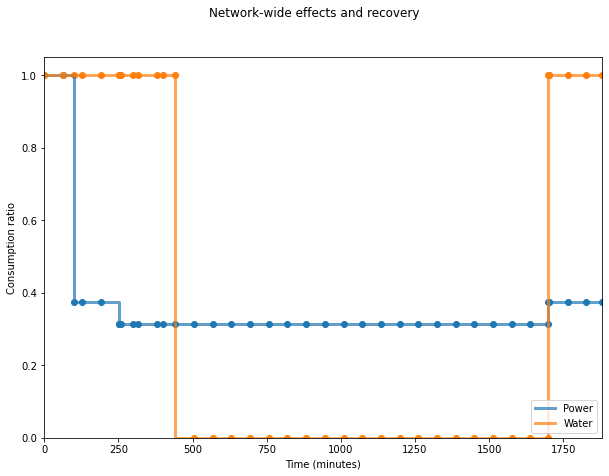

Water AUC:  0.348 	 Power AUC:  0.353 	 Weighted AUC:  0.351
Simulating the current cumulative repair order ['P_MP1', 'W_P22'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


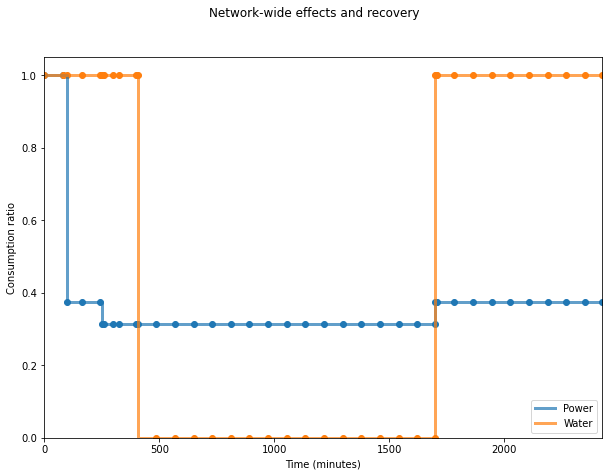

Water AUC:  0.484 	 Power AUC:  0.361 	 Weighted AUC:  0.422
Simulating the current cumulative repair order ['P_L2', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


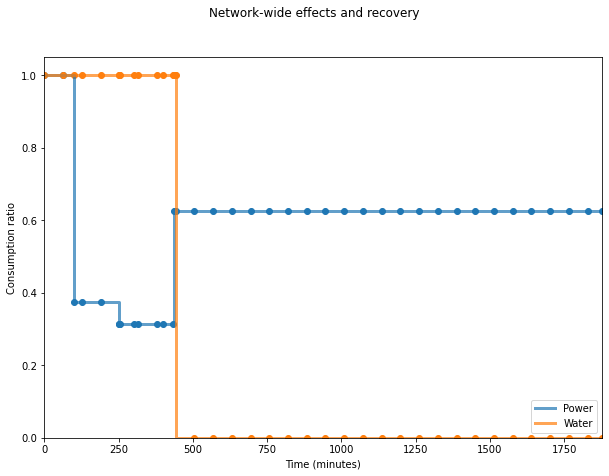

Water AUC:  0.252 	 Power AUC:  0.588 	 Weighted AUC:  0.42
Simulating the current cumulative repair order ['P_L2', 'P_LO1'] ...
   time_stamp components  fail_perc
1        6000       P_L2         50
2       18000      P_LO1         25
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


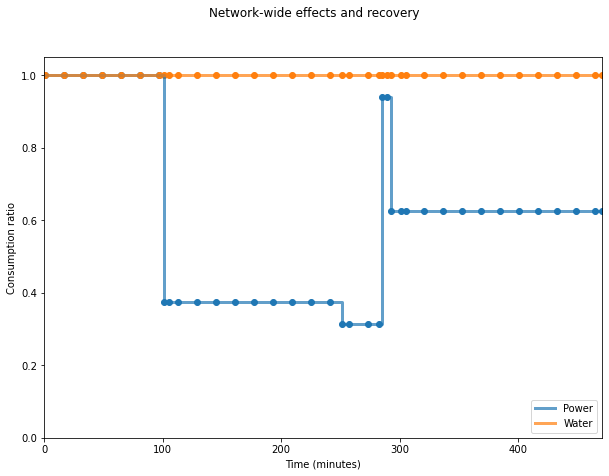

Water AUC:  0.998 	 Power AUC:  0.603 	 Weighted AUC:  0.801
Simulating the current cumulative repair order ['P_L2', 'W_P22'] ...
   time_stamp components  fail_perc
1        6000       P_L2         50
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


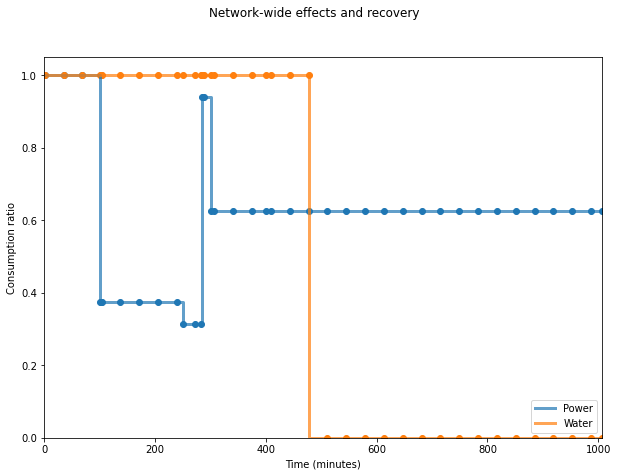

Water AUC:  0.49 	 Power AUC:  0.608 	 Weighted AUC:  0.549
Simulating the current cumulative repair order ['P_LO1', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
2       18000      P_LO1         25
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


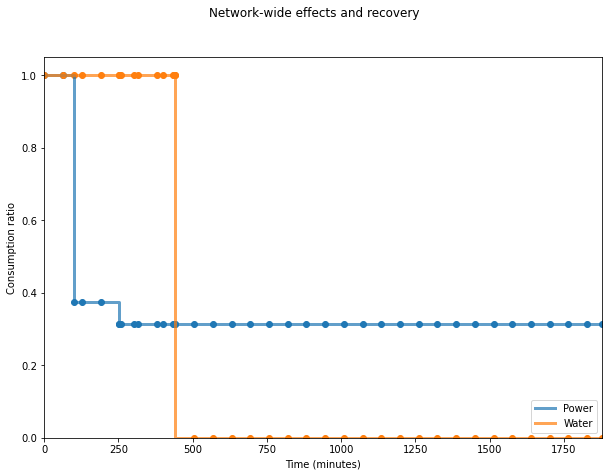

Water AUC:  0.251 	 Power AUC:  0.347 	 Weighted AUC:  0.299
Simulating the current cumulative repair order ['P_LO1', 'P_L2'] ...
   time_stamp components  fail_perc
1        6000       P_L2         50
2       18000      P_LO1         25
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


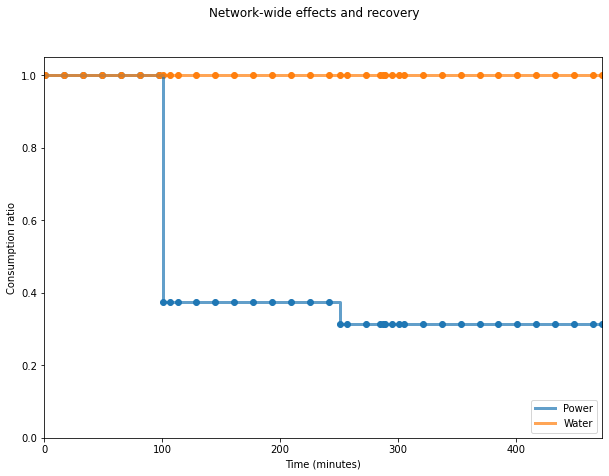

Water AUC:  0.998 	 Power AUC:  0.474 	 Weighted AUC:  0.736
Simulating the current cumulative repair order ['P_LO1', 'W_P22'] ...
   time_stamp components  fail_perc
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


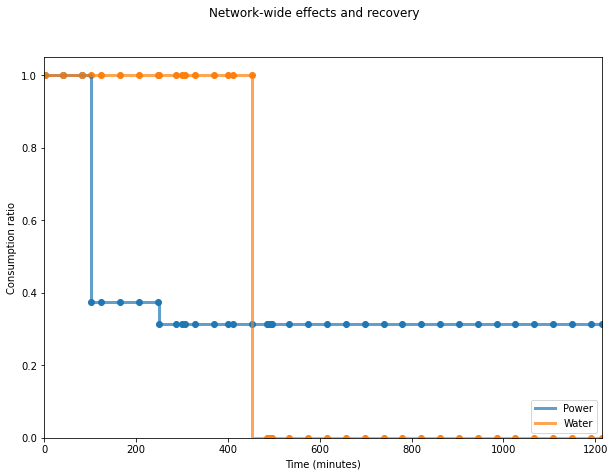

Water AUC:  0.385 	 Power AUC:  0.372 	 Weighted AUC:  0.379
Simulating the current cumulative repair order ['W_P22', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


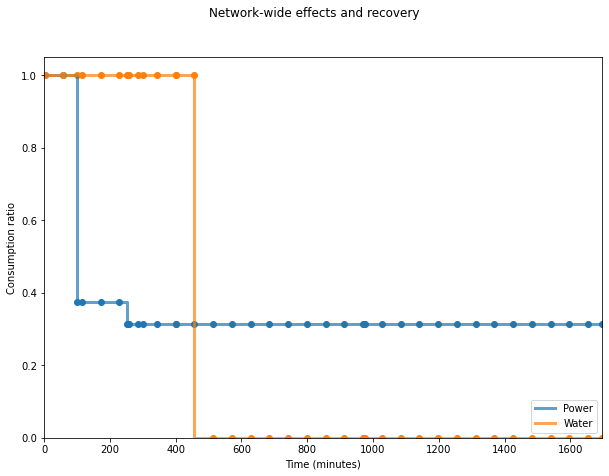

Water AUC:  0.286 	 Power AUC:  0.351 	 Weighted AUC:  0.318
Simulating the current cumulative repair order ['W_P22', 'P_L2'] ...
   time_stamp components  fail_perc
1        6000       P_L2         50
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


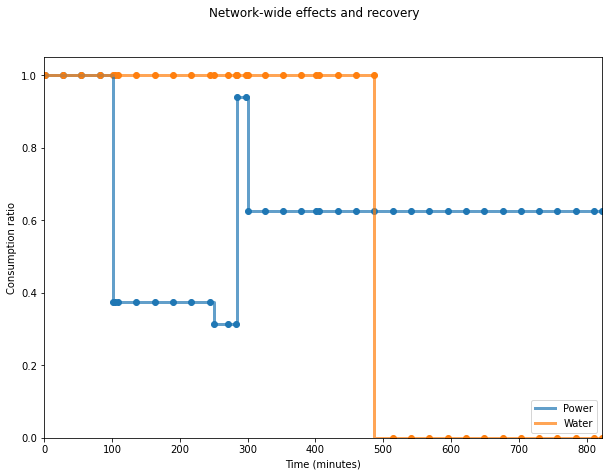

Water AUC:  0.607 	 Power AUC:  0.611 	 Weighted AUC:  0.609
Simulating the current cumulative repair order ['W_P22', 'P_LO1'] ...
   time_stamp components  fail_perc
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


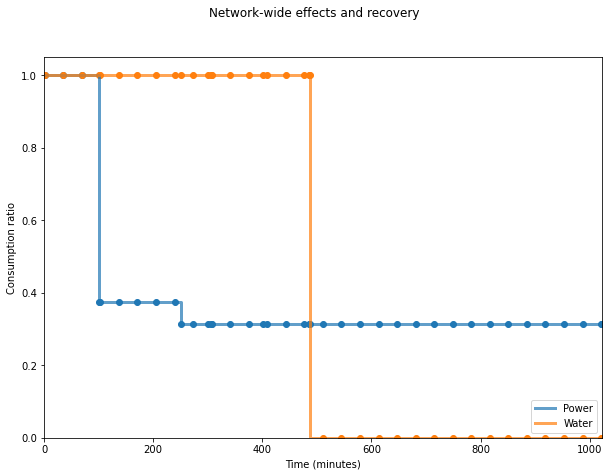

Water AUC:  0.487 	 Power AUC:  0.379 	 Weighted AUC:  0.433

P_L2 is identified as the next best repair action in the current prediction horizon. The repair order ['P_L2', 'P_LO1'] produced the highest AUC of 0.8005992476007475
--------------------------------------------------
PREDICTION HORIZON 2
**************************************************
Components to repair:  ['P_MP1', 'P_LO1', 'W_P22'] Components repaired:  ['P_L2']
Repair orders under consideration in the current prediction horizon:  [['P_MP1', 'P_LO1'], ['P_MP1', 'W_P22'], ['P_LO1', 'P_MP1'], ['P_LO1', 'W_P22'], ['W_P22', 'P_MP1'], ['W_P22', 'P_LO1']]
--------------------------------------------------
Simulating the current cumulative repair order ['P_L2', 'P_MP1', 'P_LO1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
2       18000      P_LO1         25
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_

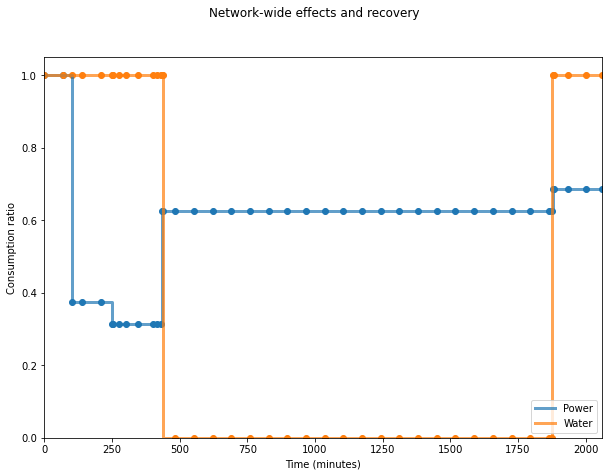

Water AUC:  0.312 	 Power AUC:  0.598 	 Weighted AUC:  0.455
Simulating the current cumulative repair order ['P_L2', 'P_MP1', 'W_P22'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


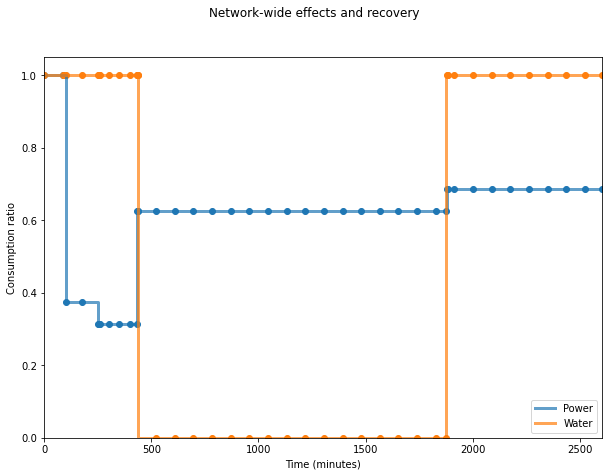

Water AUC:  0.463 	 Power AUC:  0.618 	 Weighted AUC:  0.541
Simulating the current cumulative repair order ['P_L2', 'P_LO1', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
2       18000      P_LO1         25
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


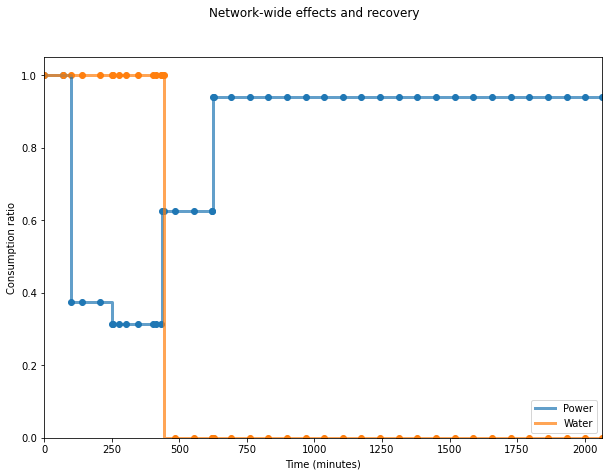

Water AUC:  0.224 	 Power AUC:  0.812 	 Weighted AUC:  0.518
Simulating the current cumulative repair order ['P_L2', 'P_LO1', 'W_P22'] ...
   time_stamp components  fail_perc
1        6000       P_L2         50
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


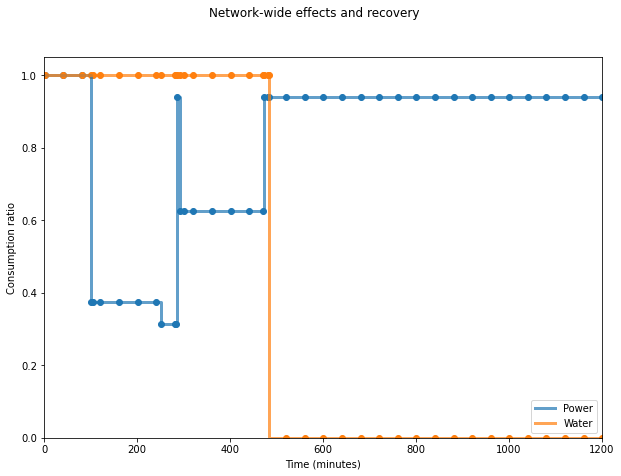

Water AUC:  0.417 	 Power AUC:  0.803 	 Weighted AUC:  0.61
Simulating the current cumulative repair order ['P_L2', 'W_P22', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


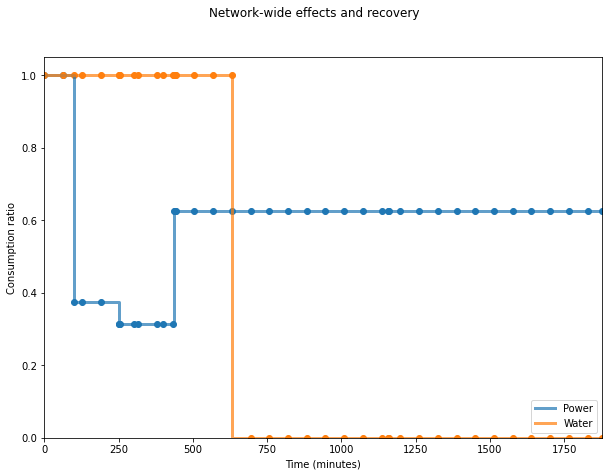

Water AUC:  0.352 	 Power AUC:  0.588 	 Weighted AUC:  0.47
Simulating the current cumulative repair order ['P_L2', 'W_P22', 'P_LO1'] ...
   time_stamp components  fail_perc
1        6000       P_L2         50
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


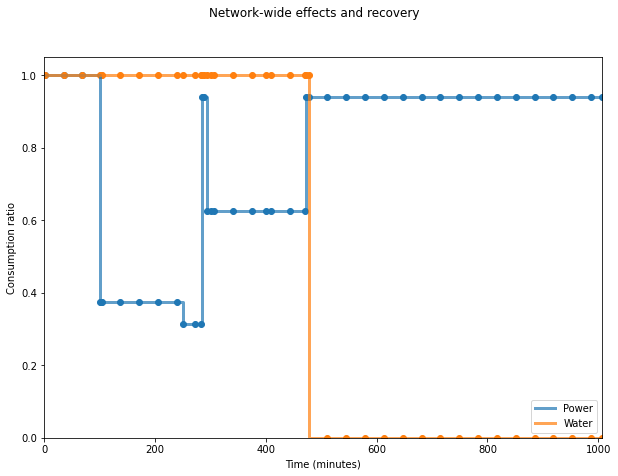

Water AUC:  0.49 	 Power AUC:  0.773 	 Weighted AUC:  0.631

W_P22 is identified as the next best repair action in the current prediction horizon. The repair order ['P_L2', 'W_P22', 'P_LO1'] produced the highest AUC of 0.6314946810347931
--------------------------------------------------
PREDICTION HORIZON 3
**************************************************
Components to repair:  ['P_MP1', 'P_LO1'] Components repaired:  ['P_L2', 'W_P22']
Repair orders under consideration in the current prediction horizon:  [['P_MP1', 'P_LO1'], ['P_LO1', 'P_MP1']]
--------------------------------------------------
Simulating the current cumulative repair order ['P_L2', 'W_P22', 'P_MP1', 'P_LO1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\drop

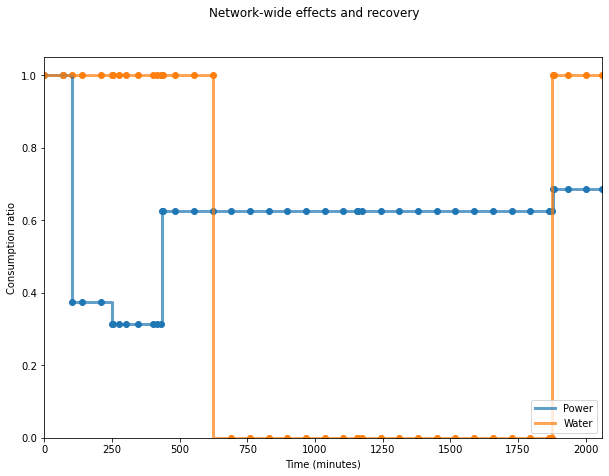

Water AUC:  0.407 	 Power AUC:  0.598 	 Weighted AUC:  0.503
Simulating the current cumulative repair order ['P_L2', 'W_P22', 'P_LO1', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\src\plots.py:375: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


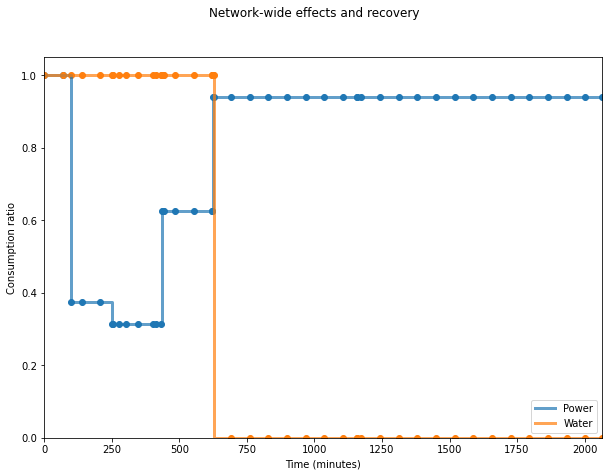

Water AUC:  0.319 	 Power AUC:  0.812 	 Weighted AUC:  0.565

P_LO1 is identified as the next best repair action in the current prediction horizon. The repair order ['P_L2', 'W_P22', 'P_LO1', 'P_MP1'] produced the highest AUC of 0.5652137769245796
--------------------------------------------------
PREDICTION HORIZON 4
**************************************************
Components to repair:  ['P_MP1'] Components repaired:  ['P_L2', 'W_P22', 'P_LO1']
Repair orders under consideration in the current prediction horizon:  [['P_MP1']]
--------------------------------------------------
Simulating the current cumulative repair order ['P_L2', 'W_P22', 'P_LO1', 'P_MP1'] ...
   time_stamp components  fail_perc
0       15000      P_MP1         75
1        6000       P_L2         50
2       18000      P_LO1         25
   time_stamp components  fail_perc
3       24000      W_P22         50
Empty DataFrame
Columns: [time_stamp, components, fail_perc]
Index: []
c:\users\srijith\dropbox\intra-create se

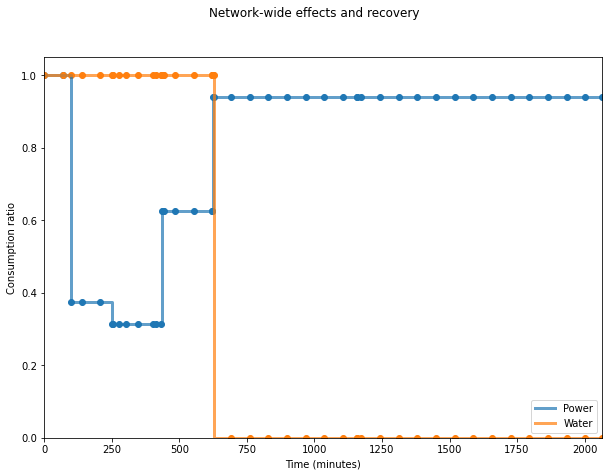

Water AUC:  0.319 	 Power AUC:  0.812 	 Weighted AUC:  0.565

P_MP1 is identified as the next best repair action in the current prediction horizon. The repair order ['P_L2', 'W_P22', 'P_LO1', 'P_MP1'] produced the highest AUC of 0.5652137769245796
--------------------------------------------------
--------------------------------------------------
Optimization completed. The MPC optimal repair order to restore the network is ['P_L2', 'W_P22', 'P_LO1', 'P_MP1'].
Process completed in  131.0  seconds


In [16]:
bf_optimizer.find_optimal_recovery(bf_simulation)

In [17]:
bf_optimizer.get_optimization_log()

,repair_order,water_auc,power_auc,auc
0,"[P_MP1, P_L2]",0.348,0.353,0.351
1,"[P_MP1, P_LO1]",0.348,0.353,0.351
2,"[P_MP1, W_P22]",0.484,0.361,0.422
3,"[P_L2, P_MP1]",0.252,0.588,0.420
4,"[P_L2, P_LO1]",0.998,0.603,0.801
5,"[P_L2, W_P22]",0.490,0.608,0.549
6,"[P_LO1, P_MP1]",0.251,0.347,0.299
7,"[P_LO1, P_L2]",0.998,0.474,0.736
8,"[P_LO1, W_P22]",0.385,0.372,0.379
9,"[W_P22, P_MP1]",0.286,0.351,0.318


## Repair order without AUC Normalization

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:0px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:3px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:0px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:3px 5px;word-break:normal;}
.tg .tg-ggg6{background-color:#ecf4ff;text-align:center;vertical-align:middle}
.tg .tg-p7n3{background-color:#ffcc67;border-color:#ffffff;font-size:small;text-align:right;vertical-align:top}
.tg .tg-fu8q{background-color:#ffccc9;border-color:#ffffff;font-size:small;text-align:right;vertical-align:top}
.tg .tg-zzct{background-color:#ffffc7;border-color:#ffffff;color:#000000;font-size:small;text-align:left;vertical-align:top}
.tg .tg-wyha{background-color:#ffffc7;text-align:center;vertical-align:middle}
.tg .tg-c06n{background-color:#507d8d;color:#ffffff;font-size:small;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-rn5w{background-color:#ecf4ff;border-color:#ffffff;font-size:small;text-align:right;vertical-align:top}
.tg .tg-5oj9{background-color:#ecf4ff;border-color:#ffffff;color:#000000;font-size:small;text-align:left;vertical-align:top}
.tg .tg-u4ur{background-color:#ffcc67;text-align:left;vertical-align:top}
.tg .tg-g1ou{background-color:#507d8d;border-color:#ffffff;color:#ffffff;font-size:small;font-weight:bold;text-align:left;
  vertical-align:top}
.tg .tg-j5y1{background-color:#507d8d;border-color:#ffffff;color:#ffffff;font-size:small;font-weight:bold;text-align:right;
  vertical-align:top}
.tg .tg-gnpy{background-color:#ffcc67;border-color:#ffffff;color:#000000;font-size:small;text-align:left;vertical-align:top}
.tg .tg-g950{background-color:#ffffc7;border-color:#ffffff;font-size:small;text-align:right;vertical-align:top}
.tg .tg-2ceo{background-color:#ffccc9;text-align:center;vertical-align:middle}
.tg .tg-h601{background-color:#ffccc9;border-color:#ffffff;color:#000000;font-size:small;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c06n">Prediction horizon</th>
    <th class="tg-g1ou"><span style="font-weight:bold">Repair order</span></th>
    <th class="tg-j5y1"><span style="font-weight:bold">AUC (water)</span></th>
    <th class="tg-j5y1"><span style="font-weight:bold">AUC (power</span></th>
    <th class="tg-j5y1"><span style="font-weight:bold">AUC (weighted)</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-ggg6" rowspan="12">1</td>
    <td class="tg-5oj9">[P_MP1, P_L2]</td>
    <td class="tg-rn5w">655.5</td>
    <td class="tg-rn5w">664.275</td>
    <td class="tg-rn5w">659.888</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_MP1, P_LO1]</td>
    <td class="tg-rn5w">655.5</td>
    <td class="tg-rn5w">664.275</td>
    <td class="tg-rn5w">659.888</td>
  </tr>
  <tr>
    <td class="tg-gnpy">[P_MP1, W_P22]</td>
    <td class="tg-p7n3">1172.5</td>
    <td class="tg-p7n3">874.649</td>
    <td class="tg-p7n3">1023.574</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_L2, P_MP1]</td>
    <td class="tg-rn5w">472.5</td>
    <td class="tg-rn5w">1104.148</td>
    <td class="tg-rn5w">788.324</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_L2, P_LO1]</td>
    <td class="tg-rn5w">470.0</td>
    <td class="tg-rn5w">284.164</td>
    <td class="tg-rn5w">377.082</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_L2, W_P22]</td>
    <td class="tg-rn5w">493.0</td>
    <td class="tg-rn5w">612.460</td>
    <td class="tg-rn5w">552.730</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_LO1, P_MP1]</td>
    <td class="tg-rn5w">472.5</td>
    <td class="tg-rn5w">652.659</td>
    <td class="tg-rn5w">562.580</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_LO1, P_L2]</td>
    <td class="tg-rn5w">472.0</td>
    <td class="tg-rn5w">224.008</td>
    <td class="tg-rn5w">348.004</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[P_LO1, W_P22]</td>
    <td class="tg-rn5w">467.5</td>
    <td class="tg-rn5w">452.282</td>
    <td class="tg-rn5w">459.891</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[W_P22, P_MP1]</td>
    <td class="tg-rn5w">484.5</td>
    <td class="tg-rn5w">594.927</td>
    <td class="tg-rn5w">539.713</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[W_P22, P_L2]</td>
    <td class="tg-rn5w">499.5</td>
    <td class="tg-rn5w">502.792</td>
    <td class="tg-rn5w">501.146</td>
  </tr>
  <tr>
    <td class="tg-5oj9">[W_P22, P_LO1]</td>
    <td class="tg-rn5w">498.0</td>
    <td class="tg-rn5w">387.499</td>
    <td class="tg-rn5w">442.749</td>
  </tr>
  <tr>
    <td class="tg-wyha" rowspan="6">2</td>
    <td class="tg-zzct">[P_MP1, P_L2, P_LO1]</td>
    <td class="tg-g950">819.5</td>
    <td class="tg-g950">795.479</td>
    <td class="tg-g950">807.490</td>
  </tr>
  <tr>
    <td class="tg-gnpy">[P_MP1, P_L2, W_P22]</td>
    <td class="tg-p7n3">1385.5</td>
    <td class="tg-p7n3">1168.191</td>
    <td class="tg-p7n3">1276.845</td>
  </tr>
  <tr>
    <td class="tg-zzct">[P_MP1, P_LO1, P_L2]</td>
    <td class="tg-g950">819.5</td>
    <td class="tg-g950">736.889</td>
    <td class="tg-g950">778.195</td>
  </tr>
  <tr>
    <td class="tg-zzct">[P_MP1, P_LO1, W_P22]</td>
    <td class="tg-g950">1391.5</td>
    <td class="tg-g950">943.903</td>
    <td class="tg-g950">1167.702</td>
  </tr>
  <tr>
    <td class="tg-zzct">[P_MP1, W_P22, P_L2]</td>
    <td class="tg-g950">1172.5</td>
    <td class="tg-g950">1044.779</td>
    <td class="tg-g950">1108.640</td>
  </tr>
  <tr>
    <td class="tg-zzct">[P_MP1, W_P22, P_LO1]</td>
    <td class="tg-g950">1172.5</td>
    <td class="tg-g950">874.649</td>
    <td class="tg-g950">1023.574</td>
  </tr>
  <tr>
    <td class="tg-2ceo" rowspan="2">3</td>
    <td class="tg-gnpy">[P_MP1, P_L2, P_LO1, W_P22]</td>
    <td class="tg-p7n3">1612.5</td>
    <td class="tg-p7n3">1532.055</td>
    <td class="tg-p7n3">1572.277</td>
  </tr>
  <tr>
    <td class="tg-h601">[P_MP1, P_L2, W_P22, P_LO1]</td>
    <td class="tg-fu8q">1385.5</td>
    <td class="tg-fu8q">1335.815</td>
    <td class="tg-fu8q">1360.657</td>
  </tr>
  <tr>
    <td class="tg-u4ur">Final repair order</td>
    <td class="tg-gnpy">[P_MP1, P_L2, P_LO1, W_P22]</td>
    <td class="tg-p7n3">1612.5</td>
    <td class="tg-p7n3">1532.055</td>
    <td class="tg-p7n3">1572.277</td>
  </tr>
</tbody>
</table>

## Repair order with AUC Normalization

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:0px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:3px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:0px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:3px 5px;word-break:normal;}
.tg .tg-v9zl{background-color:#ffffc7;border-color:#ffffff;text-align:center;vertical-align:middle}
.tg .tg-cax1{background-color:#ffccc9;border-color:#ffffff;font-size:small;text-align:left;vertical-align:middle}
.tg .tg-bxin{background-color:#ffccc9;border-color:#ffffff;text-align:center;vertical-align:middle}
.tg .tg-uw08{background-color:#ffffc7;border-color:#ffffff;text-align:right;vertical-align:middle}
.tg .tg-bpx3{background-color:#507D8D;border-color:#ffffff;color:#FFF;font-weight:bold;text-align:right;vertical-align:top}
.tg .tg-j69h{background-color:#ffcc67;border-color:#ffffff;text-align:right;vertical-align:middle}
.tg .tg-3mju{background-color:#ffcc67;border-color:#ffffff;text-align:left;vertical-align:top}
.tg .tg-thuy{background-color:#ffccc9;border-color:#ffffff;text-align:right;vertical-align:middle}
.tg .tg-g1ou{background-color:#507d8d;border-color:#ffffff;color:#ffffff;font-size:small;font-weight:bold;text-align:left;
  vertical-align:top}
.tg .tg-a3wg{background-color:#ecf4ff;border-color:#ffffff;text-align:right;vertical-align:middle}
.tg .tg-6p9g{background-color:#ffffc7;border-color:#ffffff;font-size:small;text-align:right;vertical-align:middle}
.tg .tg-3me6{background-color:#507D8D;border-color:#ffffff;color:#FFF;font-size:small;font-weight:bold;text-align:left;
  vertical-align:top}
.tg .tg-06ul{background-color:#507D8D;border-color:#ffffff;color:#FFF;font-size:small;font-weight:bold;text-align:right;
  vertical-align:top}
.tg .tg-l753{background-color:#ecf4ff;border-color:#ffffff;text-align:center;vertical-align:middle}
.tg .tg-7or5{background-color:#ecf4ff;border-color:#ffffff;font-size:small;text-align:left;vertical-align:middle}
.tg .tg-i4tg{background-color:#ecf4ff;border-color:#ffffff;font-size:small;text-align:right;vertical-align:middle}
.tg .tg-sova{background-color:#ffcc67;border-color:#ffffff;font-size:small;text-align:left;vertical-align:middle}
.tg .tg-92gf{background-color:#ffcc67;border-color:#ffffff;font-size:small;text-align:right;vertical-align:middle}
.tg .tg-ckt5{background-color:#ffffc7;border-color:#ffffff;font-size:small;text-align:left;vertical-align:middle}
.tg .tg-yquy{background-color:#ffccc9;border-color:#ffffff;font-size:small;text-align:right;vertical-align:middle}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-g1ou">Prediction horizon</th>
    <th class="tg-3me6"><span style="font-weight:bold">Repair order</span></th>
    <th class="tg-06ul"><span style="font-weight:bold">AUC (water)</span></th>
    <th class="tg-06ul"><span style="font-weight:bold">AUC (power</span></th>
    <th class="tg-bpx3"><span style="font-weight:bold">AUC (weighted)</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-l753" rowspan="12">1</td>
    <td class="tg-7or5">[P_MP1, P_L2]</td>
    <td class="tg-i4tg">0.348</td>
    <td class="tg-i4tg">0.353</td>
    <td class="tg-a3wg">0.351</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_MP1, P_LO1]</td>
    <td class="tg-i4tg">0.348</td>
    <td class="tg-i4tg">0.353</td>
    <td class="tg-a3wg">0.351</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_MP1, W_P22]</td>
    <td class="tg-i4tg">0.484</td>
    <td class="tg-i4tg">0.361</td>
    <td class="tg-a3wg">0.422</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_L2, P_MP1]</td>
    <td class="tg-i4tg">0.252</td>
    <td class="tg-i4tg">0.588</td>
    <td class="tg-a3wg">0.420</td>
  </tr>
  <tr>
    <td class="tg-sova">[P_L2, P_LO1]</td>
    <td class="tg-92gf">0.998</td>
    <td class="tg-92gf">0.603</td>
    <td class="tg-j69h">0.801</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_L2, W_P22]</td>
    <td class="tg-i4tg">0.490</td>
    <td class="tg-i4tg">0.608</td>
    <td class="tg-a3wg">0.549</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_LO1, P_MP1]</td>
    <td class="tg-i4tg">0.251</td>
    <td class="tg-i4tg">0.347</td>
    <td class="tg-a3wg">0.299</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_LO1, P_L2]</td>
    <td class="tg-i4tg">0.998</td>
    <td class="tg-i4tg">0.474</td>
    <td class="tg-a3wg">0.736</td>
  </tr>
  <tr>
    <td class="tg-7or5">[P_LO1, W_P22]</td>
    <td class="tg-i4tg">0.385</td>
    <td class="tg-i4tg">0.372</td>
    <td class="tg-a3wg">0.379</td>
  </tr>
  <tr>
    <td class="tg-7or5">[W_P22, P_MP1]</td>
    <td class="tg-i4tg">0.286</td>
    <td class="tg-i4tg">0.351</td>
    <td class="tg-a3wg">0.318</td>
  </tr>
  <tr>
    <td class="tg-7or5">[W_P22, P_L2]</td>
    <td class="tg-i4tg">0.607</td>
    <td class="tg-i4tg">0.611</td>
    <td class="tg-a3wg">0.609</td>
  </tr>
  <tr>
    <td class="tg-7or5">[W_P22, P_LO1]</td>
    <td class="tg-i4tg">0.487</td>
    <td class="tg-i4tg">0.379</td>
    <td class="tg-a3wg">0.433</td>
  </tr>
  <tr>
    <td class="tg-v9zl" rowspan="6">2</td>
    <td class="tg-ckt5">[P_L2, P_MP1, P_LO1]</td>
    <td class="tg-6p9g">0.312</td>
    <td class="tg-6p9g">0.598</td>
    <td class="tg-uw08">0.455</td>
  </tr>
  <tr>
    <td class="tg-ckt5">[P_L2, P_MP1, W_P22]</td>
    <td class="tg-6p9g">0.463</td>
    <td class="tg-6p9g">0.618</td>
    <td class="tg-uw08">0.541</td>
  </tr>
  <tr>
    <td class="tg-ckt5">[P_L2, P_LO1, P_MP1]</td>
    <td class="tg-6p9g">0.224</td>
    <td class="tg-6p9g">0.812</td>
    <td class="tg-uw08">0.518</td>
  </tr>
  <tr>
    <td class="tg-ckt5">[P_L2, P_LO1, W_P22]</td>
    <td class="tg-6p9g">0.417</td>
    <td class="tg-6p9g">0.803</td>
    <td class="tg-uw08">0.610</td>
  </tr>
  <tr>
    <td class="tg-ckt5">[P_L2, W_P22, P_MP1]</td>
    <td class="tg-6p9g">0.352</td>
    <td class="tg-6p9g">0.588</td>
    <td class="tg-uw08">0.470</td>
  </tr>
  <tr>
    <td class="tg-sova">[P_L2, W_P22, P_LO1]</td>
    <td class="tg-92gf">0.490</td>
    <td class="tg-92gf">0.773</td>
    <td class="tg-j69h">0.631</td>
  </tr>
  <tr>
    <td class="tg-bxin" rowspan="2">3</td>
    <td class="tg-cax1">[P_L2, W_P22, P_MP1, P_LO1]</td>
    <td class="tg-yquy">0.407</td>
    <td class="tg-yquy">0.598</td>
    <td class="tg-thuy">0.503</td>
  </tr>
  <tr>
    <td class="tg-sova">[P_L2, W_P22, P_LO1, P_MP1]</td>
    <td class="tg-92gf">0.319</td>
    <td class="tg-92gf">0.812</td>
    <td class="tg-j69h">0.565</td>
  </tr>
  <tr>
    <td class="tg-3mju">Final repair order</td>
    <td class="tg-sova">[P_L2, W_P22, P_LO1, P_MP1]</td>
    <td class="tg-92gf">0.319</td>
    <td class="tg-92gf">0.812</td>
    <td class="tg-j69h">0.565</td>
  </tr>
</tbody>
</table>

### Plot the direct and interdependent effects

In [65]:
location = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/test2"
simulation.write_results(
    time_tracker, power_consump_tracker, water_consump_tracker, location, plotting=False
)

The simulation results successfully saved to ..\dreaminsg_integrated_model\data\disruptive_scenarios\test2


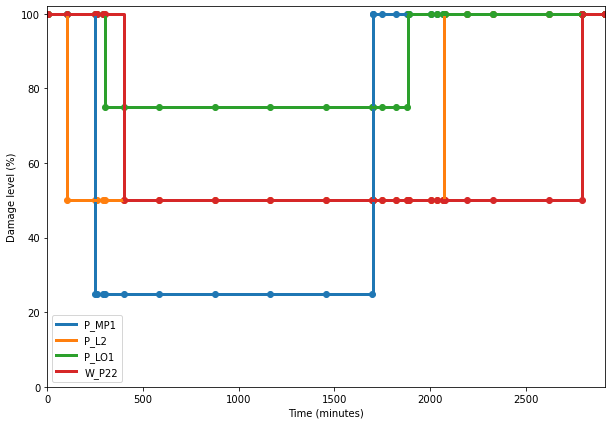

In [66]:
#Plotting repair curves
model_plots.plot_repair_curves(motor_failure, scatter = True)

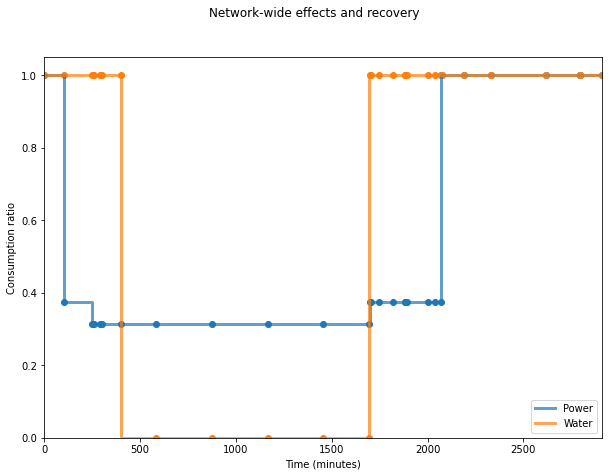

In [68]:
model_plots.plot_interdependent_effects(power_consump_tracker, water_consump_tracker, time_tracker, scatter = True)